## Reload the `EC_estimator.py` code to consider any changes

In [194]:
#reload model magic
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


import EC_estimator as annec

In [195]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tabulate import tabulate
import EC_estimator as annec
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Model

## Load the dataset, preprocessing, and apply ANN model

In [196]:
# Load data
df = annec.load_data('Inputs/inputs.csv')
df_var = annec.df_by_variable(df)



# Split data
train_rows = df_var.shape[0] - 6039
df_train, df_test = annec.split_data(df_var, train_rows, 6039)

# Build model inputs
inputs = annec.build_model_inputs(df_var)

# Preprocessing layers
layers = annec.preprocessing_layers(df_var, inputs)

# Build model
neurons = [8, 2, 1]  # This is an example; adapt it to your needs
activations = ['sigmoid', 'sigmoid']
model, tensorboard_cb = annec.build_model(layers, inputs)


X_train = [ df_train.loc[:, pd.IndexSlice[feature,annec.lags_feature[feature]]] for feature in annec.feature_names()]

y_train = df_train[('EC','0d')].to_frame()  # situation where one column is produced and coerced to a series
# Otherwise you would do something like:
#y.droplevel(level='lag',axis=1).rename(mapper={"EC":"emm_ec"})
y_train.columns = ["emm_ec"]



X_test = [ df_test.loc[:, pd.IndexSlice[feature,annec.lags_feature[feature]]] for feature in annec.feature_names()]


y_test = df_test[('EC','0d')].to_frame()  # Only works for univariate dataset where it is a series
y_test.columns = ["emm_ec"] 


# Train model
history, model = annec.train_model(model, tensorboard_cb, X_train, y_train, X_test, y_test)

## Illustration of by-variable input (df_var)

In [197]:
df = annec.load_data('Inputs/inputs.csv')

# This will break up the incoming DataFrame into a MultiIndex column
# with the site/variable (e.g. Sac) as the 0-level index and
# lag (e.g. '3d') as the fast index.
df_var = annec.df_by_variable(df)

# This is an illustration of how to extract a single location/variable
# so that it (with its lags) can be used as a single input in the ANN. 
# In the traditional CalSIM model would be 18 values 
# The droplevel gets rid of the vestiges of the multiindex
sac = df_var.loc[:, pd.IndexSlice['sac',:]].droplevel(level="var",axis=1)
print(sac.head(4))





lag           0d           1d           2d           3d           4d  \
0    22290.01548  22333.70068  22358.59029  22373.94862  22383.92889   
1    22203.28407  22290.01548  22333.70068  22358.59029  22373.94862   
2    21992.03107  22203.28407  22290.01548  22333.70068  22358.59029   
3    18938.58199  21992.03107  22203.28407  22290.01548  22333.70068   

lag           5d           6d           7d         1ave         2ave  \
0    22390.61113  22395.12267  22398.10862  22391.45013  20455.31666   
1    22383.92889  22390.61113  22395.12267  22394.40549  21187.05572   
2    22373.94862  22383.92889  22390.61113  22396.15244  21864.78865   
3    22358.59029  22373.94862  22383.92889  22396.79180  22157.44139   

lag         3ave         4ave         5ave         6ave         7ave  \
0    13808.89333  13727.31347  15871.35388  18889.58980  19086.62041   
1    13863.05279  13723.46477  15415.59194  18875.79859  19027.33307   
2    13971.76887  13721.41293  14965.45140  18855.52854  18992

## Evaluation of the model

In [218]:
# Calculate metrics for ANN
#print(model.summary())
metrics = []
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("predictions")
print(y_train_pred[-4:-1])
print(y_test_pred[-4:-1])
print("input data")
print(X_train[0].iloc[-4:-1])
print(X_test[0].iloc[-4:-1])
print("end predictions")
metrics.append(annec.calculate_metrics('ANN', y_train, y_train_pred, y_test, y_test_pred))

df3 = pd.DataFrame(metrics)

#print(tabulate(df3, headers='keys', tablefmt='psql'))



189/189 [==============================] - 1s 3ms/step
predictions
[[3295.7021]
 [3430.7017]
 [3538.958 ]]
[[2290.895 ]
 [2287.8262]
 [2455.1255]]
input data
var            sac                                                      \
lag             0d           1d           2d           3d           4d   
33754  7785.670076  7799.537119  7808.753521  7815.169612  7819.799191   
33755  7763.476647  7785.670076  7799.537119  7808.753521  7815.169612   
33756  7724.776026  7763.476647  7785.670076  7799.537119  7808.753521   

var                                                                     \
lag             5d           6d           7d         1ave         2ave   
33754  7823.235474  7825.844312  7827.861244  7833.139374  7798.669268   
33755  7819.799191  7823.235474  7825.844312  7832.484449  7807.586937   
33756  7815.169612  7819.799191  7823.235474  7831.658644  7816.464872   

var                                                                     \
lag           3ave        

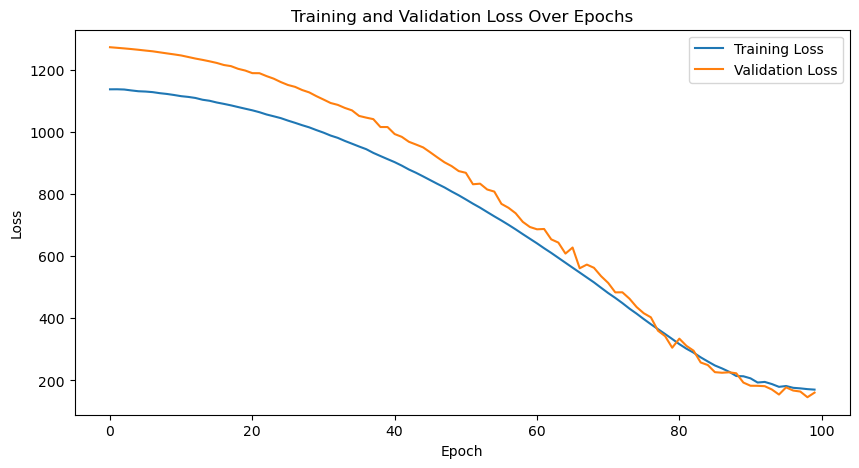

In [199]:
annec.plot_history(history)

## Plot the ANN prediction versus the test target as a time series

0    2757.110352
Name: 6038, dtype: float32


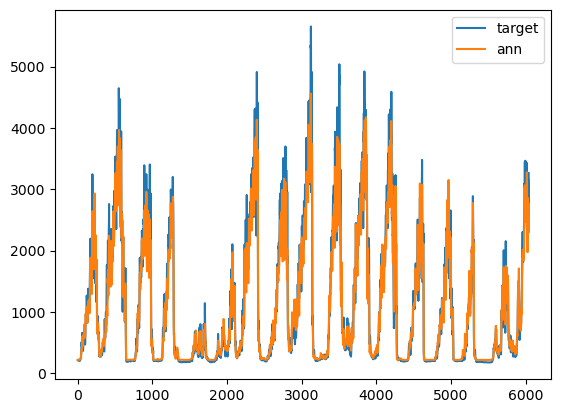

In [217]:
import matplotlib.pyplot as plt
ax = y_test.plot()
pred = pd.DataFrame(index=y_test.index,data= y_test_pred)
print(pred.iloc[-1])
pred.plot(ax=ax)
plt.legend(["target","ann"])

## Save the final model

In [190]:
############################################################################################
############# Please change the model_save_path to the direction you saved the files #######
############################################################################################

model_save_path = r'./Export/emmaton'
annec.save_model(model, model_save_path)

INFO:tensorflow:Assets written to: ./Export/emmaton\assets
Model saved at location: ./Export/emmaton


dd

In [191]:
def root_mean_squared_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

loaded_model = tf.keras.models.load_model(model_save_path, custom_objects={'root_mean_squared_error': root_mean_squared_error})
# Calculate metrics for ANN
metrics = []
y_train_pred = loaded_model.predict(X_train)
y_test_pred = loaded_model.predict(X_test)
metrics.append(annec.calculate_metrics('ANN', y_train, y_train_pred, y_test, y_test_pred))

df3 = pd.DataFrame(metrics)
print(tabulate(df3, headers='keys', tablefmt='psql'))


189/189 [==============================] - 1s 3ms/step
+----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------+
|    | Model   |   Train_R2 |   Train_RMSE |   Train_Percentage_Bias |   Test_R2 |   Test_RMSE |   Test_Percentage_Bias |
|----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------|
|  0 | ANN     |       0.98 |       134.25 |                    4.47 |      0.97 |      183.95 |                   2.05 |
+----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------+


## Load the saved model and test it with dataset and one sample

Currently this tests Emmaton at a time when EC is 200-ish which is not a very compelling example. It also appears to use the same inputs as the test/training process, so the above example should cover it.

In [239]:
def root_mean_squared_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

loaded_model = tf.keras.models.load_model(model_save_path, custom_objects={'root_mean_squared_error': root_mean_squared_error})
# Calculate metrics for 

df_sample = pd.read_csv("F:/projects/ann_calsim_ec_estimator/Inputs/selected.csv", header=None)
input_sample = [frame.to_frame().to_numpy().transpose() for ndx,frame in df_sample.iterrows()] 
print("Sample")
print(input_sample)
y_sample_pred = loaded_model.predict(input_sample)
print(y_sample_pred)





in
var            sac                                                          \
lag             0d            1d            2d            3d            4d   
0     22290.015480  22333.700680  22358.590290  22373.948620  22383.928890   
1     22203.284070  22290.015480  22333.700680  22358.590290  22373.948620   
2     21992.031070  22203.284070  22290.015480  22333.700680  22358.590290   
3     18938.581990  21992.031070  22203.284070  22290.015480  22333.700680   
4     18157.222480  18938.581990  21992.031070  22203.284070  22290.015480   
...            ...           ...           ...           ...           ...   
6034   7178.489123   7169.338157   7147.221362   7067.043165   6879.099909   
6035   7183.190302   7178.489123   7169.338157   7147.221362   7067.043165   
6036   7185.981787   7183.190302   7178.489123   7169.338157   7147.221362   
6037   7187.839785   7185.981787   7183.190302   7178.489123   7169.338157   
6038   7189.208433   7187.839785   7185.981787   7183.190302 